In [1]:
import sys
import torch
import string
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
all_categories = ["normal", "attack"]
n_categories = len(all_categories)
category_lines = {}

PATH_NORMAL = "dataset/normal.txt"
PATH_ATTACK = "dataset/attack.txt"

def readLines(filename: str) -> list[str]:
    lines = open(filename, encoding="utf-8").read().strip().split("\n")
    return lines

def removeBlankLines(file_path: str) -> None:
    with open(file_path, 'r') as f:
        lines = [line for line in f if line.strip()]

    with open(file_path, 'w') as f:
        f.writelines(lines)

removeBlankLines(PATH_NORMAL)
removeBlankLines(PATH_ATTACK)
lines_normal = readLines(PATH_NORMAL)  # list_of_normal
lines_attack = readLines(PATH_ATTACK)  # list_of_attack
lines_all = lines_normal + lines_attack

category_lines["normal"] = lines_normal
category_lines["attack"] = lines_attack

In [3]:
all_char = string.printable
n_all_char = len(all_char)


def char2index(char: str):
    return all_char.find(char)


def char2tensor(char: str):
    tensor = torch.zeros(1, n_all_char)
    tensor[0][char2index(char)] = 1
    return tensor


def line2tensor(line: str):
    tensor = torch.zeros(len(line), n_all_char)
    for i, char in enumerate(line):
        tensor[i][char2index(char)] = 1
    return tensor

In [4]:
class URLDataset(Dataset):
    def __init__(self, lines_normal, lines_attack, lines_all):
        self.len = len(lines_normal) + len(lines_attack)
        self.normal_tensor = torch.zeros((len(lines_normal)), dtype=torch.long)
        self.attack_tensor = torch.ones(len(lines_attack), dtype=torch.long)
        self.x_data = [line2tensor(line) for line in tqdm(lines_all)]
        self.x_raw = lines_all
        self.y_data = torch.cat((self.normal_tensor, self.attack_tensor), dim=0)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index], self.x_raw[index]

    def __len__(self):
        return self.len


In [5]:
dataset = URLDataset(lines_normal, lines_attack, lines_all)
train_dataset, test_dataset = random_split(dataset, lengths=[0.6, 0.4])
train_size = len(train_dataset)
test_size = len(test_dataset)
train_loader = DataLoader(dataset=train_dataset, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, shuffle=True, num_workers=0)

100%|██████████| 79046/79046 [00:14<00:00, 5342.96it/s] 


In [6]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [7]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()

        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = torch.nn.RNN(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=num_layers,
        )
        self.h2o = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input):
        hidden = torch.zeros(self.num_layers, self.hidden_size)
        input, _ = self.rnn(input, hidden)
        output = self.h2o(input[-1, :])
        return output.unsqueeze(0)


input_size = n_all_char
output_size = 2
hidden_size = 128
num_layers = 2
learning_rate = 0.00008
rnn = RNN(input_size, hidden_size, output_size, num_layers)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

epoch=1 iter=5000 0.05271% 0.29925 attack YES /wdb-description/                              
epoch=1 iter=10000 0.10542% 0.00039 attack YES /scripts/save.php?file_save=/etc/passwd       
epoch=1 iter=15000 0.15813% 0.08496 normal YES /config.rb                                     
epoch=1 iter=20000 0.21085% 0.00131 attack YES /examples/servlets/servlet/perl.exe?-v         
epoch=1 iter=25000 0.26356% 0.20768 normal YES /revision.txt                                  
epoch=1 iter=30000 0.31627% 0.00021 attack YES /phpdebug_PATH/test/debug_test.php?debugClassLocation=XXpathXX
epoch=1 iter=35000 0.36898% 0.01521 attack YES /2017/index.php?a=lists&agent=&bedroom=&c=index&catid=8&city=beijing&m=content&page=&pay_type_int=4%20onmonmouseoverouseover=alert(42873)%20y=&price=&rent_mode=&zone=3363
epoch=1 iter=40000 0.42169% 0.00040 attack YES /myhome/space.php?id=-9828%27%29%20OR%20%28SELECT%208896%20FROM%28SELECT%20COUNT%28%2A%29%2CCONCAT%280x3a636b663a%2C%28SELECT%20%28CASE%20WHEN%20%288896

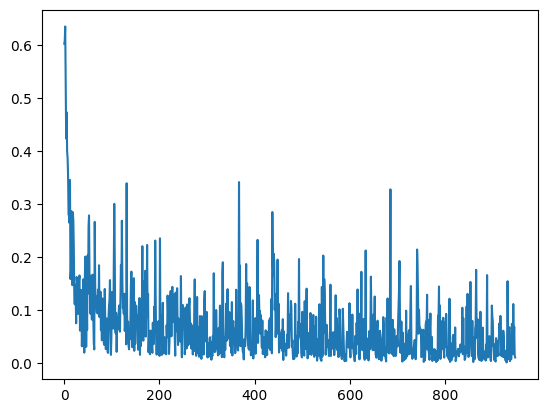

In [8]:
EPOCHS = 2
print_every = 5000
plot_every = 100

plt.figure()
all_losses = []

def train(epoch):
    total_loss = 0
    current_loss = 0
    num_correct = 0
    bar = tqdm(enumerate(train_loader, start=1), total=train_size, file=sys.stdout)
    bar.set_description(f"Epoch [{epoch}/{EPOCHS}]")
    for iter, (line_tensor, category_tensor, line) in bar:
        output = rnn(line_tensor[0])
        loss = criterion(output, category_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        current_loss += loss.item()
        guess, guess_i = categoryFromOutput(output)
        category_i = category_tensor.item()
        num_correct += 1 if guess_i == category_i else 0
        bar.set_postfix_str(
            f"loss={loss.item():.6f}, acc={(num_correct / iter * 100):.3f}",
            refresh=False,
        )

        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            category = all_categories[category_tensor.item()]
            correct = "YES" if guess_i == category_i else f"NO ({category})"
            tqdm.write(
                f"epoch={epoch} iter={iter} {(iter + (epoch - 1) * train_size) / (train_size * EPOCHS):.5f}% {loss:.5f} {guess} {correct} {line[0]}"
            )
        
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

    return total_loss


def test():
    num_correct = 0
    with torch.no_grad():
        bar = tqdm(enumerate(test_loader, start=1), total=test_size, file=sys.stdout)
        bar.set_description("TEST")
        for iter, (line_tensor, category_tensor, line) in bar:
            output = rnn(line_tensor[0])
            guess, guess_i = categoryFromOutput(output)
            category_i = category_tensor.item()
            num_correct += 1 if guess_i == category_i else 0
        acc = num_correct / test_size * 100
        print(f"Test set: Accuracy {num_correct} / {test_size} {acc:.2f} %")


for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test()
    state = {"state": rnn.state_dict(), "epoch": iter}
    filename = "pt/" + str(epoch * train_size) + ".pt"
    torch.save(state, filename)

# clear_output(wait=True)
plt.plot(all_losses)
plt.show()